In [1]:
# Define the types used in the notebook

from typing import FrozenSet, Tuple, Set

# Colors
BLACK = 0
BLUE = 1
RED = 2
GREEN = 3
YELLOW = 4
GREY = 5
PINK = 6
ORANGE = 7
LBLUE = 8
BROWN = 9
BLANK = 42


Grid = Tuple[Tuple[int]]
Color = int
Cell = Tuple[Color, Tuple[int, int]]
Object = FrozenSet[Cell]

In [2]:
# Define plotting function to visualise grids

import numpy as np

import matplotlib.pyplot as plt

def plot_colored_grid(grid: Grid) -> None:
    # Create color map
    colors = {
        BLACK: 'black',
        BLUE: 'blue', 
        RED: 'red',
        GREEN: 'green',
        YELLOW: 'yellow',
        GREY: 'grey',
        PINK: 'pink',
        ORANGE: 'orange',
        LBLUE: 'lightblue',
        BROWN: 'brown',
        BLANK: 'white'
    }
    
    # Convert grid to numpy array
    grid_array = np.array(grid)
    
    # Create figure and axis
    plt.figure(figsize=(3, 3))
    
    # Plot colored cells
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            color = colors[grid[i][j]]
            plt.fill([j, j+1, j+1, j], [i, i, i+1, i+1], color=color, edgecolor='black')
            
    # Set plot properties
    plt.xlim(-0.1, len(grid[0])+0.1)
    plt.ylim(-0.1, len(grid)+0.1)
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

In [3]:
def get_objects(grid: Grid) -> int:
    """
    Get the objects in a grid. An object is defined as a set of cells
    that have the same color and are connected. Two cells are connected
    if they are adjacent (horizontally or vertically).
    """
    visited: set[Tuple[int, int]] = set()
    objects: set[Object] = set()
    coords = {(i, j) for i in range(len(grid)) for j in range(len(grid[0]))}
    for i, j in coords:
        # Skip if already visited
        if (i, j) in visited:
            continue
        visited.add((i, j))
        object = {(grid[i][j], (i, j))}
        curr_color = grid[i][j]
        stack: list[Tuple[int, int]] = [(i, j)]
        while stack:
            curr_coord = stack.pop()
            neighbors = [
                (curr_coord[0] + dx, curr_coord[1] + dy)
                for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1))
            ]
            for neighbor in neighbors:
                if (
                    neighbor in coords
                    and neighbor not in visited
                    and grid[neighbor[0]][neighbor[1]] == curr_color
                ):
                    visited.add(neighbor)
                    stack.append(neighbor)
                    object.add((grid[neighbor[0]][neighbor[1]], neighbor))
        final_object: Object = frozenset(object)
        objects.add(final_object)
    return objects
                        

In [4]:
def filter_touch_border(objects: set[Object], grid: Grid) -> Set[Object]:
    """
    Filter objects that touch the border of the grid.
    """
    found_objs = set()
    for obj in objects:
        coords = {cell[1] for cell in obj}
        if any(
            coord[0] == 0 or coord[0] == len(grid) - 1 or
            coord[1] == 0 or coord[1] == len(grid[0]) - 1
            for coord in coords
        ):
            found_objs.add(obj)
    return found_objs

def filter_color(objects: set[Object], color: Color) -> Set[Object]:
    """
    Filter objects by color.
    """
    return {obj for obj in objects if any(cell[0] == color for cell in obj)}

def xor_objs(objects: set[Object]) -> Set[Object]:
    """
    Combine all objects into a single object.
    """
    xor_result = set()
    for obj in objects:
        xor_result ^= obj
    return xor_result

def or_objs(objects: set[Object]) -> Set[Object]:
    """
    Combine all objects into a single object.
    """
    or_result = set()
    for obj in objects:
        or_result |= obj
    return or_result

def find_neighbors(obj: Object, incl_diag=False, incl_self=False) -> Set[Tuple[int, int]]:
    """
    Find all the neighbors of the cells in the object.
    A neighbor is defined as a cell that is adjacent (horizontally or vertically)
    to a cell in the object.
    """
    neighbors = set()
    diffs = ((-1, 0), (1, 0), (0, -1), (0, 1))
    if incl_diag:
        diffs += ((-1, -1), (-1, 1), (1, -1), (1, 1))
    for cell in obj:
        for dx, dy in diffs:
            neighbor = (cell[1][0] + dx, cell[1][1] + dy)
            if neighbor in obj and not incl_self:
                continue
            neighbors.add(neighbor)
    return neighbors

def touching_cells(objs1: Set[Object], objs2: Set[Object], incl_diag=False) -> Set[Object]:
    """
    Find all the cells of objs1 that are touching any cell of objs2.
    """
    unified_obj1 = or_objs(objs1)
    unified_obj2 = or_objs(objs2)
    return {frozenset({(BLANK, neigh) for neigh in find_neighbors(unified_obj1, incl_diag=incl_diag) if neigh in {cell[1] for cell in unified_obj2}})}

def touching_objects(objs1: Set[Object], objs2: Set[Object], incl_diag=False) -> Set[Object]:
    """
    Find all the objects of objs1 that are touching any object of objs2.
    """
    unified_obj1 = or_objs(objs1)
    result = set()
    neighbors = find_neighbors(unified_obj1, incl_diag=incl_diag)
    for neigh in neighbors:
        for obj in objs2:
            if neigh in {cell[1] for cell in obj}:
                result.add(obj)
                break
    return result


def change_color(objects: Set[Object], color: Color) -> Object:
    """
    Change the color of all cells in the object to the given color.
    """
    return {frozenset({(color, cell[1]) for cell in obj}) for obj in objects}

def write_on_grid(objects: Set[Object], grid: Grid) -> Grid:
    """
    Write the objects on the grid.
    """
    new_grid = [list(row) for row in grid]
    for obj in objects:
        for cell in obj:
            new_grid[cell[1][0]][cell[1][1]] = cell[0]
    return tuple(tuple(row) for row in new_grid)

In [5]:
def solve(grid: Grid) -> Grid:
    """
    Solve the new problem.
    """
    objects = get_objects(grid)
    black_objects = filter_color(objects, BLACK)
    border_black_objects = filter_touch_border(black_objects, grid)
    inner_black_objects = xor_objs([black_objects, border_black_objects])
    blue_objects = filter_color(objects, BLUE)
    closed_blue_objects = change_color(touching_objects(inner_black_objects, blue_objects, incl_diag=True), BLUE)
    outer_border = change_color(touching_cells(closed_blue_objects, border_black_objects, incl_diag=True), RED)
    inner_border = change_color(touching_cells(closed_blue_objects, inner_black_objects, incl_diag=True), GREEN)
    new_grid = write_on_grid(outer_border | inner_border, grid)
    return new_grid

In [ ]:
# Import the grids from a json file
# I found it here: https://github.com/mxbi/arckit/blob/main/arckit/data/arcagi_aa922be.json

import json

def read_input_file(filename: str) -> Grid:
    with open(filename, 'r') as f:
        data = json.load(f)
    grids = []
    for g in data["train"]:
        grids.append(g["input"])
    for g in data["test"]:
        grids.append(g["input"])
    # change grid colors
    # 0 -> BLACK, 1 -> BLUE
    for grid in grids:
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 0:
                    grid[i][j] = BLACK
                elif grid[i][j] == 1:
                    grid[i][j] = BLUE
                else:
                    raise ValueError(f"Unknown color: {grid[i][j]}")
    # Convert the JSON data to the Grid type (Tuple[Tuple[int]])
    return [tuple(tuple(row) for row in grid) for grid in grids]

input_grids = read_input_file("input.json")

Original grid:


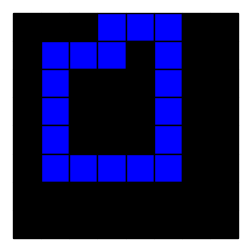

Solved grid:


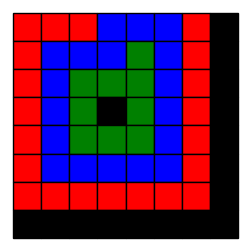

Original grid:


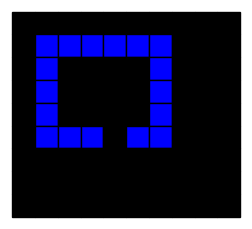

Solved grid:


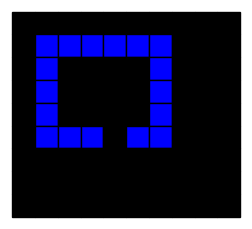

Original grid:


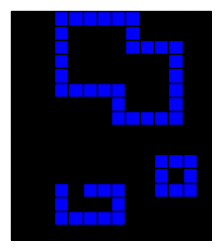

Solved grid:


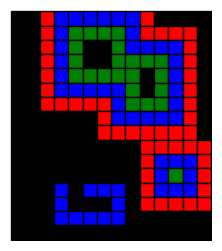

Original grid:


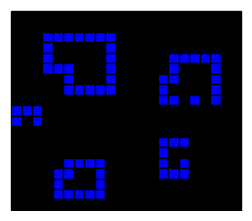

Solved grid:


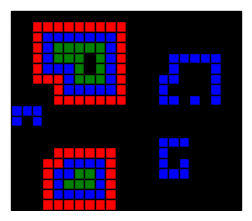

Original grid:


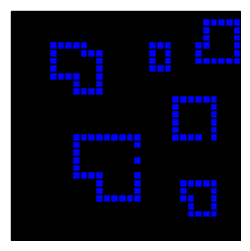

Solved grid:


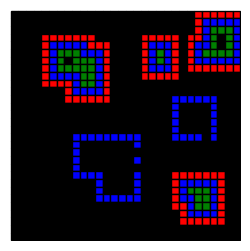

In [ ]:
# Solve the grids and plot them

for grid in input_grids:
    print("Original grid:")
    plot_colored_grid(grid)
    print("Solved grid:")
    plot_colored_grid(solve(grid))